# Local plane fit for vector angle calculation

This script implements the idea of fitting a local plane to each DS vector for a 2D angle calculation relative to the eye´s equator.
<br>The idea is simple and it follows these steps:
1. Getting reliable xyz column coordinates and reference lines in the medulla layer M10
2. Getting a local (x,y) plane for each column
3. Getting all the desired vectors on the local planes
4. Getting a local (x,y) plane for each of these vectors
5. Projecting these vectors and the appropriate reference equator line on that plane
6. Calculating the angle between each vector and a reference line

In [1]:
# Importing some packages
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import math
import numpy as np
import pandas as pd
import seaborn as sns
import os
from fafbseg import flywire
from helper import combine_xyz, get_hexagons_reference_equators, match_pq_to_equators, add_equator_match_ids,  find_nearest_neighbors, project_to_2d_plane,fit_reference_line_to_plane
from helper import plot_hex_grid, plot_tetra_grid, draw_vector,color_polygons_reference_equators, plot_nearest_neighbors, plot_local_plane_coords, plot_nearest_neighbors_and_vector


C:\Users\smolina\Anaconda3\envs\EM2\lib\site-packages\blessed\terminal.py:183: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


## 1. Getting reliable xyz column coordinates and reference lines in the medulla layer M10

### 1.1 Creating the column grid

Using data from Codex, we build the regular eye´s column grid using Mi1s

In [2]:
# Some user parameters
cell_for_grid = 'Mi1'

In [3]:
# Importing data from Codex
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_columns.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_data = pd.read_csv(filePath, compression='gzip')
columns_id_data.rename(columns={"cell id": "root_id","cell type": "cell_type","column id": "column_id" }, inplace= True)

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'column_assignment.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_coordinates = pd.read_csv(filePath, compression='gzip')

In [4]:
# Looking deeply at the match between individual cells and individual columns
cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_for_grid]
number_unique_cells = len(cells_columns['root_id'].unique())
if 'not assigned' in cells_columns['column_id'].unique():
    number_unique_columns = len(cells_columns['column_id'].unique())-1 #-1 to compensate for "not assigned label" of some cells
else:
    number_unique_columns = len(cells_columns['column_id'].unique())
    

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')

# Addining column coordinates information
df_grid =  pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
print(f'Final df_grid length: {len(df_grid)}')
display(df_grid.head())

Total number of unique cells: 796
Total number of unique columns: 796
Missmatch: 0
Number of duplicates / cells not assigned to columns: 0
Filtered data length: 796
Final df_grid length: 796


,root_id,cell_type,column_id,p,q,x,y
0,720575940603042272,Mi1,1,12,1,6,13
1,720575940603200428,Mi1,2,9,-7,8,2
2,720575940603327916,Mi1,3,-12,0,-6,-12
3,720575940603935334,Mi1,4,-6,-15,5,-21
4,720575940604151008,Mi1,6,0,-4,2,-4


### 1.2. Getting Mi1 centroids

The following sections are code in development and do not necessarily have to be finished.
The idea of placing Mi1 based on synapse location instead of the exact center of each column coordinate has been discussed.
Nevertheless, I temporarily leave this code here in case the idea is discussed again.
<br><br>Analisis flow
<br><br>
All in a loop across mi1 cells:
1. Getting pre-synaptic sites
2. PCA to get the depth axis of each Mi1
3. Select the last points belonging to layer M9-10
4. Calculate a centroid
5. Define this centroid as the Mi1 terminal location

In [5]:
## Getting Mi1 positions (terminals)

## RUN ONLY ONCE
'''
# Getting pre-synaptic sites
terminal_position_ls = []
curr_id_ls = df_grid.root_id.tolist()
output_df = flywire.synapses.get_synapses(curr_id_ls, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True)

# Saving the output_df file in a csv file

fileName = 'Mi1_pre_sites.csv'
savingPath = os.path.join(dataPath,'from_FAFBseg-py',fileName)
# saving the dataframe
output_df.to_csv(savingPath, index=False)

'''

"\n# Getting pre-synaptic sites\nterminal_position_ls = []\ncurr_id_ls = df_grid.root_id.tolist()\noutput_df = flywire.synapses.get_synapses(curr_id_ls, pre=True, post=False, attach=True, \n                                             min_score=50, clean=True, transmitters=False, \n                                             neuropils=True, batch_size=30, \n                                             dataset='production', progress=True)\n\n# Saving the output_df file in a csv file\n\nfileName = 'Mi1_pre_sites.csv'\nsavingPath = os.path.join(dataPath,'from_FAFBseg-py',fileName)\n# saving the dataframe\noutput_df.to_csv(savingPath, index=False)\n\n"

In [6]:
#Loading the data from the csv file
fileName = 'Mi1_pre_sites.csv'
savingPath = os.path.join(dataPath,'from_FAFBseg-py',fileName)
pre_sites_df = pd.read_csv(savingPath)
combine_xyz(pre_sites_df)

In [7]:
# PCA to get the depth axis of each Mi1
centroid_ls = []
root_id_ls =[]
centroid_x_ls = []
centroid_y_ls = []
centroid_z_ls = []
for root_id in pre_sites_df.pre_pt_root_id.unique():
    # Getting single Mi1 pre synaptic sites
    curr_df = pre_sites_df[pre_sites_df.pre_pt_root_id == int(root_id)]
    temp_positions_pre_syn = np.array(curr_df.pre_pt_position.values)
    # Convert list of lists to a 2D NumPy array
    positions_pre_syn = np.array([np.array(lst) for lst in temp_positions_pre_syn])
    
    #Doing PCA
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)  # Reduce to 3 components (since we have 3D data)
    pca_result = pca.fit_transform(positions_pre_syn)
    
    
    pc1 = pca_result[:, 0] # Get the PC1 axis (1st principal component)
    sorted_indices = np.argsort(pc1)[::-1]  # Sort points based on their PC1 values, descending order
    if root_id in [720575940626852201,720575940632527524]:
        sorted_indices = np.argsort(pc1) # Hard coding PC1 axis for two ids.
        
    num_points = len(pc1) # Select the top 10% from the end 
    bottom_10_percent_idx = sorted_indices[-int(0.1 * num_points):]  # Take the last 10%  
    bottom_10_percent_points = positions_pre_syn[bottom_10_percent_idx] # Get the original points corresponding to the top 10% in PC1
    
    #Calculating the centroid of those points (center of mass)
    centroid = bottom_10_percent_points.mean(axis=0) # Calculate the center of mass by taking the mean of each coordinate (x, y, z)
    centroid_ls.append(centroid)
    root_id_ls.append(root_id)
    centroid_x_ls.append(centroid[0]*4)
    centroid_y_ls.append(centroid[1]*4)
    centroid_z_ls.append(centroid[2]*40)

centroids_df = pd.DataFrame({'centroid_M10':centroid_ls,'centroid_x':centroid_x_ls,'centroid_y':centroid_y_ls,'centroid_z':centroid_z_ls, 'root_id':root_id_ls})
# Merge to add from_cell_type
df_grid_extended = centroids_df.merge(
    df_grid,
    how='left',
    left_on='root_id',
    right_on='root_id'
)

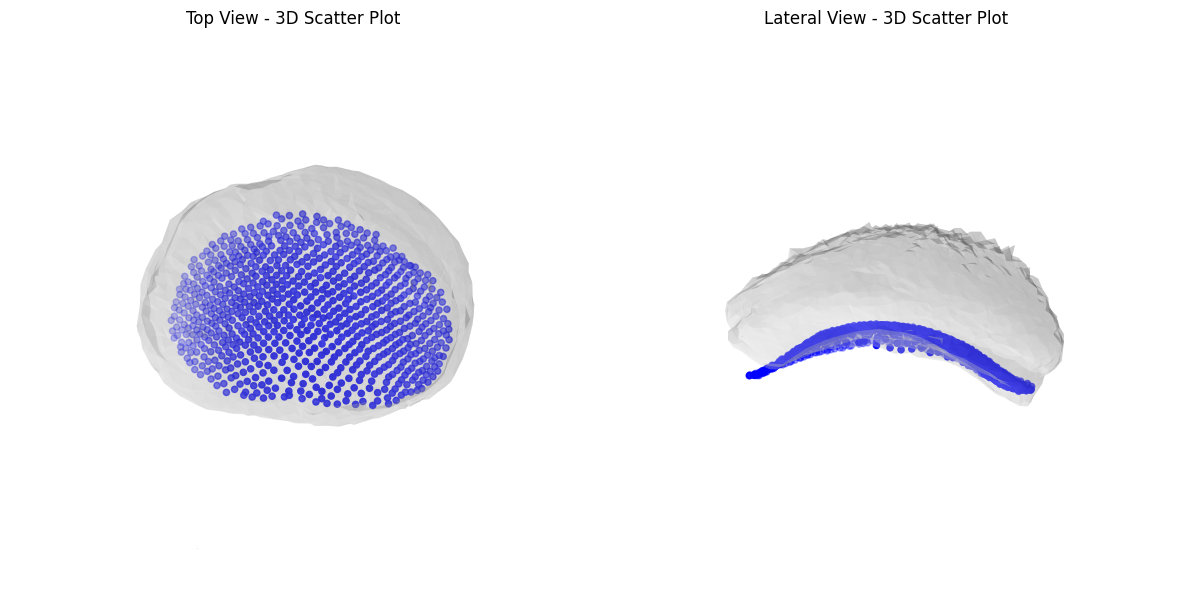

In [8]:
## Looking at the extracted centroids with respect to the medulla

import navis
import matplotlib.pyplot as plt

neurpile_mesh = 'ME_L'

# Viewing angles for top view and lateral view
top_view_azim = 16
top_view_elev = -50
lateral_view_azim = 4
lateral_view_elev = -130

# Example data for x, y, z coordinates
x = centroid_x_ls
y = centroid_y_ls
z = centroid_z_ls

# Create a figure with 1 row and 2 columns for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))

# Get the mesh data
OL_R = flywire.get_neuropil_volumes([neurpile_mesh])

# First subplot: Top view
navis.plot2d([OL_R], method='3d_complex', ax=ax1, scalebar='20 um')
ax1.azim = top_view_azim
ax1.elev = top_view_elev
ax1.scatter(x, y, z, c='b', marker='o')
#ax1.set_xlabel('X Position')
#ax1.set_ylabel('Y Position')
#ax1.set_zlabel('Z Position')
ax1.set_axis_off()
ax1.set_title('Top View - 3D Scatter Plot')

# Second subplot: Lateral view
navis.plot2d([OL_R], method='3d_complex', ax=ax2, scalebar='20 um')
ax2.azim = lateral_view_azim
ax2.elev = lateral_view_elev
ax2.scatter(x, y, z, c='b', marker='o')
#ax2.set_xlabel('X Position')
#ax2.set_ylabel('Y Position')
#ax2.set_zlabel('Z Position')
ax2.set_axis_off()
ax2.set_title('Lateral View - 3D Scatter Plot')

# Display the plot
plt.tight_layout()
plt.show()

### 1.3. Create reference curves that cove the eye (D-V)

In [9]:
# Coordinates list for an initial reference line
reference_axes_dict = {}
reference_axes_dict['h_x_ls'] = list(range(-18,18+1,1)) # equator (h) reference x coordinates
reference_axes_dict['h_y_ls'] = list(range(18,-18-1,-1))# equator (h) reference y coordinate


In [10]:
# Calculate all reference lines parallel to the equator (h)
equators_list = get_hexagons_reference_equators(reference_axes_dict, map_type='regular', x_start = -30, x_steps = 60)
# Match each line to each grid column coordinate
df_grid_extended = match_pq_to_equators(df_grid_extended, equators_list)
# Add the equator_match_ids column
df_grid_extended = add_equator_match_ids(df_grid_extended)


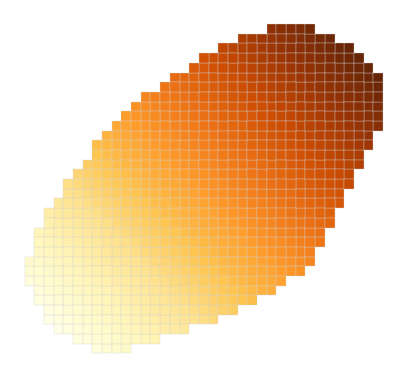

In [11]:
## Visualizing the different equator parallel lines

## Defining labels: choose your option
# 1) "manual_labels" column ids
labels = df_grid_extended.column_id.tolist() 
# 2) "manual_labels" original coordinates
labels = list(zip(df_grid_extended.p, df_grid_extended.q)) 
labels = [f"({x}, {y})" for x, y in labels]

original_p = df_grid_extended['p'].tolist()
original_q = df_grid_extended['q'].tolist()
# Grid
#fig, ax, hexagons = plot_hex_grid(original_p, original_q, hex_size=0.5, spacing=1.0, fig_size=(5, 5), labels=labels, label_type=None, text_size=6)
fig, ax, tetragons = plot_tetra_grid(original_p, original_q, spacing=1, fig_size=(5, 5), labels=labels, label_type=None, text_size=6)

# Coloring the reference axes
color_polygons_reference_equators(df_grid_extended,tetragons,reference_axes_dict, map_type ='regular', x_start = -30, x_steps = 60)

plt.show()

# 2. Getting a local (x,y) plane for each column


In [12]:
# Find the nearest_neighbors of each column to define the local plane and store their colum ids
total_number_of_neighbors = 24
df_grid_extended = find_nearest_neighbors(df_grid_extended, n_neighbors=total_number_of_neighbors)

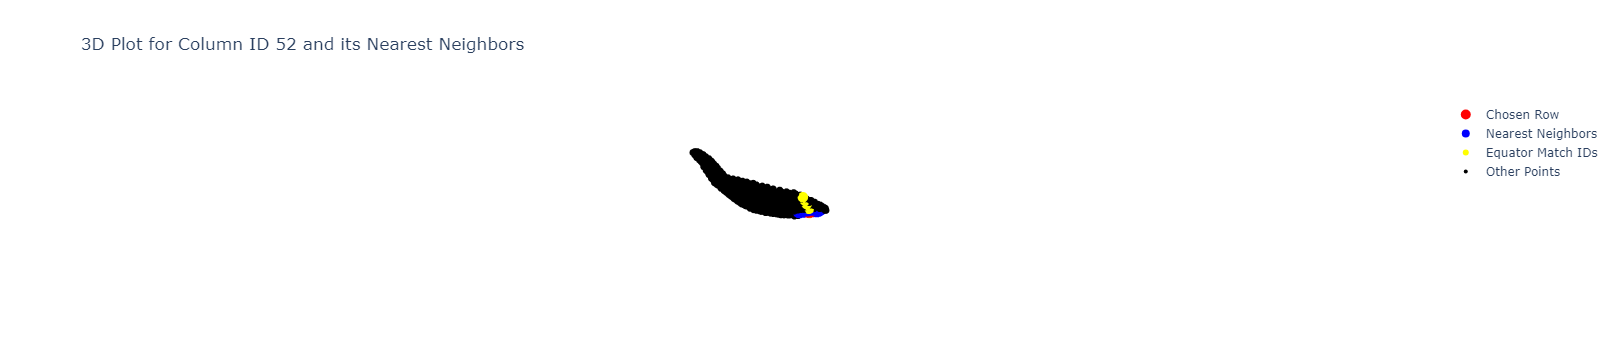

In [31]:
# Check specific future local "planes"
fig = plot_nearest_neighbors(df_grid_extended, chosen_column_id='52')
savePath = r'D:\Connectomics-Data\FlyWire\Html-plots'
fileName = 'column_neighbors_medulla.html'
saveName = os.path.join(savePath, fileName)
fig.write_html(saveName)

In [16]:
# Use PCA to get the local plane and project the dots onto that plane
df_grid_extended = project_to_2d_plane(df_grid_extended)

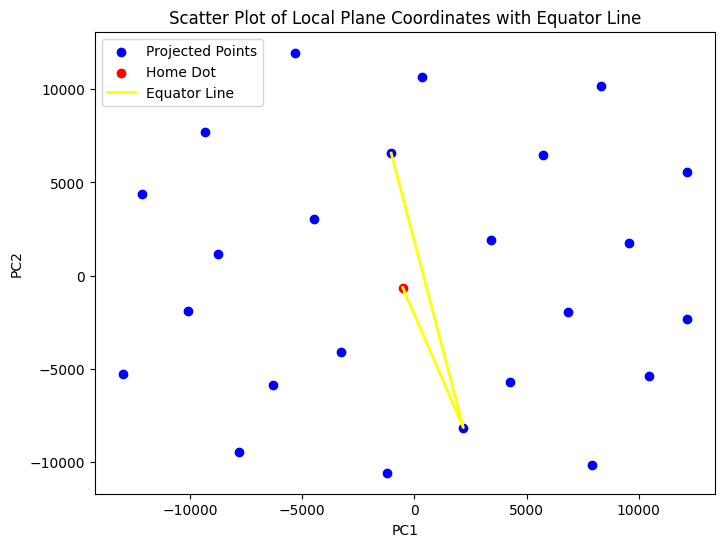

In [17]:
_column_id = '52'

# Extract nearest neighbors and equator match IDs for a given column_id
chosen_row = df_grid_extended[df_grid_extended['column_id'] == _column_id]
local_plane_coords_row = chosen_row.local_plane_coords

if chosen_row.empty:
    print("Column ID '5' not found.")
else:
    nearest_neighbors = chosen_row['nearest_neighbours'].values[0]
    equator_match_ids = chosen_row['equator_match_ids'].values[0]

    # Convert equator_match_ids to a set for faster lookup
    equator_match_ids_set = set(equator_match_ids)

    # Find positions of nearest neighbors that are in equator_match_ids
    positions = [i for i, neighbor in enumerate(nearest_neighbors) if neighbor in equator_match_ids_set]


reference_equator_coord_2D = []
for pos in positions:
    temp_coord = local_plane_coords_row.values.tolist()[0][pos]
    reference_equator_coord_2D.append(temp_coord)
#Add the position of the chosen column id
home_dot_coord = chosen_row.home_dot_coords.values.tolist()[0]
home_dot_coord_array = np.array(home_dot_coord)
reference_equator_coord_2D = np.vstack([reference_equator_coord_2D, home_dot_coord_array])



# Sample data from df_grid_extended for 'given' column_id 
local_plane_coords = np.array(df_grid_extended[df_grid_extended.column_id == _column_id].local_plane_coords.tolist()[0])
local_home_coords = np.array(df_grid_extended[df_grid_extended.column_id == _column_id].home_dot_coords.tolist()[0])
x_plane = local_plane_coords[:, 0]
y_plane = local_plane_coords[:, 1]
x_home = local_home_coords[0]
y_home = local_home_coords[1]

# Reference equator coordinates (example values or calculated previously)
reference_equator_coord_2D = np.array(reference_equator_coord_2D)  # Convert to numpy array if not already

# Extract x and y coordinates for the yellow line from reference_equator_coord_2D
x_equator = reference_equator_coord_2D[:, 0]
y_equator = reference_equator_coord_2D[:, 1]

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_plane, y_plane, color='blue', label='Projected Points')
plt.scatter(x_home, y_home, color='red', label='Home Dot')

# Add the yellow line passing through reference equator points
plt.plot(x_equator, y_equator, color='yellow', label='Equator Line', linewidth=2)

# Add title and labels
plt.title("Scatter Plot of Local Plane Coordinates with Equator Line")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

# Show the plot
plt.show()

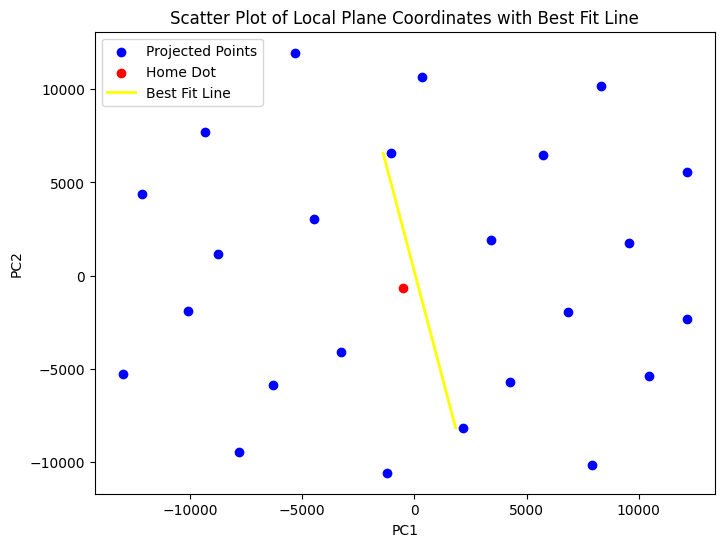

In [18]:
# Fit reference line to local plane
_column_id = '52'
x_plane, y_plane, x_home, y_home, x_fit, y_fit = fit_reference_line_to_plane(df_grid_extended, _column_id)

# -------- First Figure: Scatter plot with the best fit line --------
plt.figure(figsize=(8, 6))
plt.scatter(x_plane, y_plane, color='blue', label='Projected Points')
plt.scatter(x_home, y_home, color='red', label='Home Dot')

# Add the regression line for the reference equator points
plt.plot(x_fit, y_fit, color='yellow', label='Best Fit Line', linewidth=2)

# Add title and labels
plt.title("Scatter Plot of Local Plane Coordinates with Best Fit Line")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

# Show the plot
plt.show()

# 3. Getting all the desired vectors on the local planes

In [24]:
# Loading data from saved files (courtesy of Maria)
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'mi1_mi4_centers_T4a.csv'
filePath = os.path.join(dataPath,fileName)
centers_data = pd.read_csv(filePath)

In [25]:
## T4 subtype-specific data frame
# Create a new DataFrame that only includes rows from df_grid_extended where root_id is in centers_data.Mi1_ID
filtered_df_grid_extended = df_grid_extended[df_grid_extended['root_id'].isin(centers_data['Mi1_ID'])]
# Merging data from T4 subtype file
filtered_df_grid_extended = pd.merge(filtered_df_grid_extended, centers_data, left_on='root_id', right_on='Mi1_ID', how='left')

In [26]:
filtered_df_grid_extended[filtered_df_grid_extended.column_id == '52']

,centroid_M10,centroid_x,centroid_y,centroid_z,root_id,cell_type,column_id,p,q,x,...,home_dot_coords,T4_ID,Mi1_ID,Mi4_ID,center_mi1_x,center_mi1_y,center_mi1_z,center_mi4_x,center_mi4_y,center_mi4_z


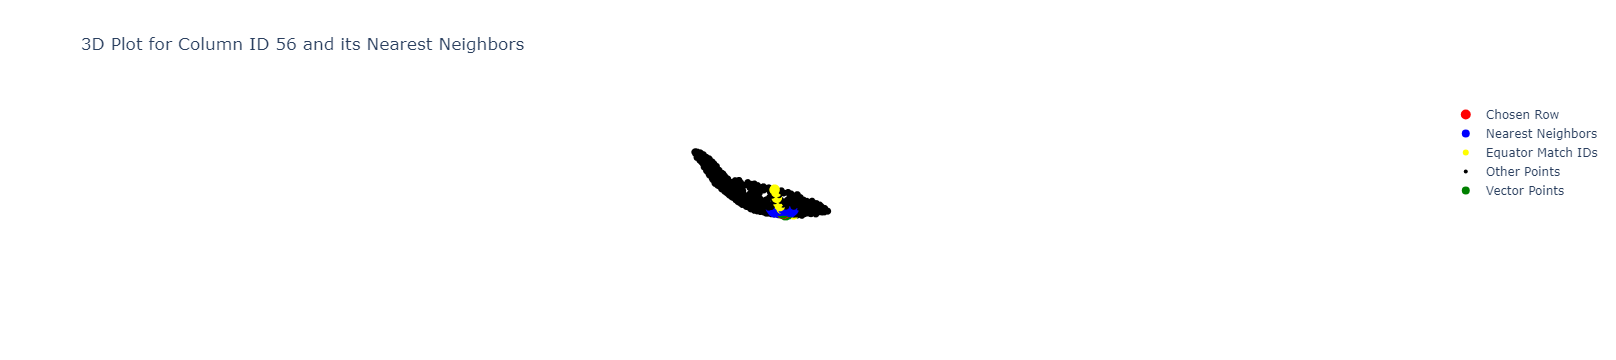

In [32]:
# Check specific future local "planes" together with the vector start and end coordinates
fig = plot_nearest_neighbors_and_vector(filtered_df_grid_extended, chosen_column_id='56')
savePath = r'D:\Connectomics-Data\FlyWire\Html-plots'
fileName = 'column_neighbors_medulla_and_vector_points.html'
saveName = os.path.join(savePath, fileName)
fig.write_html(saveName)

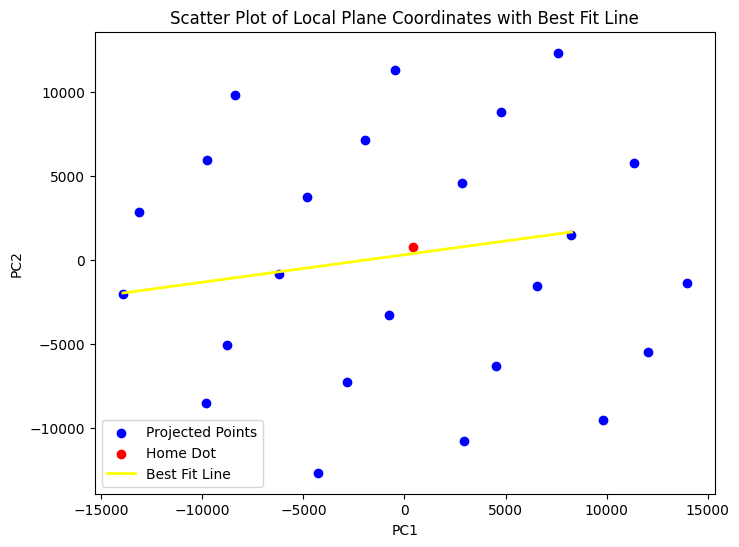

In [29]:
# Fit reference line to local plane
_column_id = '56'
x_plane, y_plane, x_home, y_home, x_fit, y_fit = fit_reference_line_to_plane(filtered_df_grid_extended, _column_id)
# Dots for the vector:
# x_vector = []
# x_vector.append(filtered_df_grid_extended[filtered_df_grid_extended.column_id == '56'].vector_dots_coords.values[0]['start'][0])
# x_vector.append(filtered_df_grid_extended[filtered_df_grid_extended.column_id == '56'].vector_dots_coords.values[0]['end'][0])
# y_vector = []
# y_vector.append(filtered_df_grid_extended[filtered_df_grid_extended.column_id == '56'].vector_dots_coords.values[0]['start'][1])
# y_vector.append(filtered_df_grid_extended[filtered_df_grid_extended.column_id == '56'].vector_dots_coords.values[0]['end'][1])


# -------- First Figure: Scatter plot with the best fit line --------
plt.figure(figsize=(8, 6))
plt.scatter(x_plane, y_plane, color='blue', label='Projected Points')
plt.scatter(x_home, y_home, color='red', label='Home Dot')
# plt.scatter(x_vector, y_vector, color='green', label='Vector Dot')

# Add the regression line for the reference equator points
plt.plot(x_fit, y_fit, color='yellow', label='Best Fit Line', linewidth=2)

# Add title and labels
plt.title("Scatter Plot of Local Plane Coordinates with Best Fit Line")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

# Show the plot
plt.show()

# 4. Projecting these vectors and the appropriate reference equator line on that plane


# 5. Calculating the angle between each vector and a reference line